# ANAC


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tf
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import LabelEncoder


#### Seed

In [37]:
seed = 2024
np.random.seed(seed)

In [38]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_96752/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [39]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
# merge whole df with own generated RecipeMatchesDiet

### Data Cleaning

#### Basics

In [40]:
# drop na diet column
df = df.dropna(subset=['Diet'])
# Rename AuthorId column
df.rename(columns= {
    "AuthorId" : "CustomerId", 
    "Time": "MaxTime"
}, inplace=True)

df["Like"] = df["Like"].astype("boolean")
# Change types into category and mapping values
df["Diet"] = df["Diet"].astype("category")

df["RecipeCategory"] = df["RecipeCategory"].astype("category")

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighCalories'] = df['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No' }
df['HighProtein'] = df['HighProtein'].map(mapping_protein).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['LowFat'] = df['LowFat'].map(mapping_cal).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No' }
df['LowSugar'] = df['LowSugar'].map(mapping_sugar).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighFiber'] = df['HighFiber'].map(mapping_cal).astype('category')

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)


# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=['Diet','RecipeCategory', 'HighCalories', 'LowFat', 'HighFiber', 'HighProtein', 'LowSugar'], drop_first=True)

df.rename(columns={
    'HighCalories_Yes': 'want_HighCalories',
    'LowFat_Yes':'want_LowFat',
    'HighFiber_Yes':'want_HighFiber',
    'HighProtein_Yes':'want_HighProtein',
}, inplace=True)

df["DifferenceRequestedAndTimeNeeded"] = df["MaxTime"] - (df["CookTime"] + df["PrepTime"])

In [41]:
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

def check_keywords(ingredients):
    has_animal_product = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "milk", "butter", "egg", "cheese", "breast", "gelatin", "honey", "tuna", "steak", "salmon", "shrimps"]) for ingredient in ingredients)
    has_fish_or_meat = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "tuna", "steak", "salmon", 'shrimps']) for ingredient in ingredients)
    return has_animal_product, has_fish_or_meat

df[['has_animal_product', 'has_fish_meat']] = df['RecipeIngredientParts'].str.split(',').apply(check_keywords).apply(pd.Series)

df['for_Vegan'] = ~df['has_animal_product'] & ~df['has_fish_meat']
df['for_Vegetarian'] = (df['has_animal_product'] & ~df['has_fish_meat']) | (~df['has_animal_product'] & ~df['has_fish_meat'])
df['Correct_Diet'] = (~df['Diet_Vegetarian'] & ~df['Diet_Vegan']) | (df['Diet_Vegan'] & df['for_Vegan']) | (df['Diet_Vegetarian']  & df['for_Vegetarian'] )



***Split data***

In [42]:
# Split data into train and test set
train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

# Handling outliers

In [43]:
train_set = train_set[train_set["Calories"] < 300000]

### Missing values

In [44]:
train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)

In [45]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set.loc[:, 'RecipeServings'] = train_set['RecipeServings'].fillna(recipesServings_mean)
test_set.loc[:, 'RecipeServings'] = test_set['RecipeServings'].fillna(recipesServings_mean)

# Bool To numeric

In [46]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['Diet_Vegan', 'Diet_Vegetarian', 'RecipeCategory_Bread', 'RecipeCategory_Breakfast', 'RecipeCategory_Lunch', 'RecipeCategory_One dish meal', 'RecipeCategory_Other', 'RecipeCategory_Soup', 'want_HighCalories', 'want_LowFat', 'want_HighFiber', 'want_HighProtein', 'LowSugar_No', 'Correct_Diet']

label_encoder = LabelEncoder()

for column in columns_to_encode:
    train_set.loc[:, column] = label_encoder.fit_transform(train_set[column])
    test_set.loc[:, column] = label_encoder.fit_transform(test_set[column])


/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_96752/2792886431.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_set.loc[:, column] = label_encoder.fit_transform(train_set[column])
/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_96752/2792886431.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_set.loc[:, column] = label_encoder.fit_transform(test_set[column])
/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_96752/2792886431.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 1 1 1]' has dtype incompatibl

***Train Model***


In [47]:
#Variables that are good according to xgboost: 

#variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', "Calories", "SaturatedFatContent", "SugarContent", "CookTime", "PrepTime", "Diet_Vegan", "Diet_Vegetarian", "RecipeCategory_Bread", "RecipeCategory_Other", "RecipeCategory_Breakfast", "RecipeCategory_Lunch", "RecipeCategory_Soup", "RecipeCategory_One dish meal", "LowSugar_No", "CholesterolContent", "SodiumContent", "FiberContent", "RecipeServings", "Time", "HighCalories", "HighFiber"]

variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product']
X = train_set.drop(variables_to_drop, axis=1)
y = train_set['Like']
test_set = test_set.drop(variables_to_drop, axis=1)

In [48]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=seed)

In [54]:
X_train = normalize(X_train, axis=0)
X_test = normalize(X_test, axis=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Create a neural network

In [55]:
from keras.src.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=28))
model.add(Dense(128, activation='relu', input_dim=28))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

hist = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test))

/Users/my/BAML/venv3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)               │      3,712 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 20,353 (79.50 KB)

 Trainable params: 20,353 (79.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.8690 - loss: 0.3300 - val_accuracy: 0.8923 - val_loss: 0.2591
Epoch 2/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8930 - loss: 0.2524 - val_accuracy: 0.8981 - val_loss: 0.2437
Epoch 3/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8981 - loss: 0.2382 - val_accuracy: 0.9000 - val_loss: 0.2377
Epoch 4/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.9002 - loss: 0.2379 - val_accuracy: 0.8741 - val_loss: 0.4393
Epoch 5/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8843 - loss: 0.3711 - val_accuracy: 0.8939 - val_loss: 0.2801
Epoch 6/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8979 - loss: 0.2693 - val_accuracy: 0.8977 - val_loss: 0.2552
Epoch 7/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8866 - loss: 0.2909 - val_accuracy: 0.8961 - val_loss: 0.2610
Epoch 8/20
682/682 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8984 - loss: 0.2542 - 

7937
9046

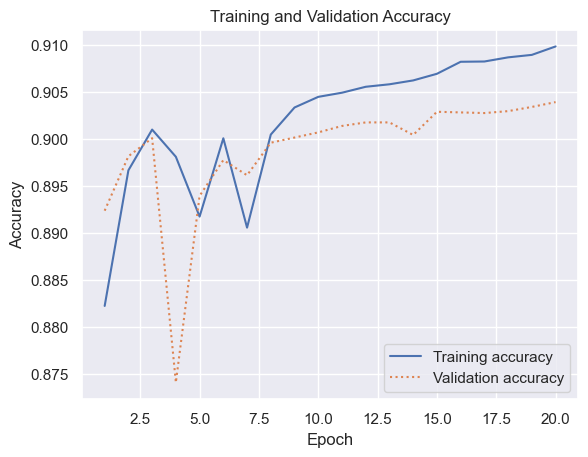

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()  # Removed the unnecessary plt.plot() line


913/913 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Test Balanced Accuracy: 0.7275214374973287


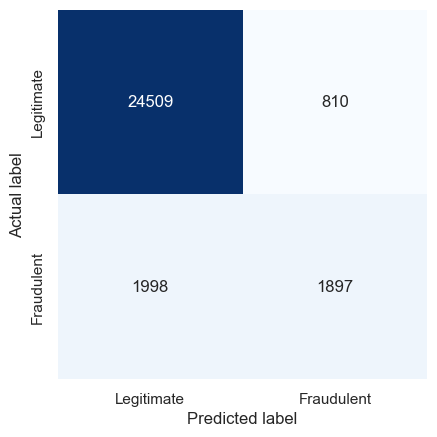

In [57]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc = balanced_accuracy_score(y_test, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc}')

In [58]:

# Assuming you have the confusion matrix 'mat'
true_negative, false_positive, false_negative, true_positive = mat.ravel()

# Calculate Sensitivity (True Positive Rate)
sensitivity = true_positive / (true_positive + false_negative)

# Calculate Specificity (True Negative Rate)
specificity = true_negative / (true_negative + false_positive)

# Calculate Balanced Accuracy
balanced_accuracy = (sensitivity + specificity) / 2

print(f'Balanced Accuracy: {balanced_accuracy:.4f}')


Balanced Accuracy: 0.7275


***Output file with test set***